In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import json
from pathlib import Path
import numpy as np

# ---------- exact value -> folder token (no scientific notation) ----------
def _fmt_exact(v) -> str:
    v = float(v)
    if v.is_integer():
        return str(int(v))                 # 10.0 -> "10"
    s = f"{v:.12f}".rstrip("0").rstrip(".")  # 0.001 -> "0.001"; 0.1 -> "0.1"
    if s == "-0":  # just in case of -0.0 formatting
        s = "0"
    return s

# ---------- build the exact run directory ----------
def _run_dir_exact(root, lam, alpha, m0):
    root = Path(root)
    d = root / f"lambda_{_fmt_exact(lam)}" / f"alpha_{_fmt_exact(alpha)}" / f"m0_{_fmt_exact(m0)}"
    return d if d.is_dir() else None

# ---------- utilities to extract a speed ----------
def _slope_vs_time(t, xf, use_last_frac=0.5):
    t = np.asarray(t, float)
    xf = np.asarray(xf, float)
    n = len(t)
    if n < 4 or xf.shape[0] != n:
        return np.nan
    i0 = max(0, int(np.floor((1.0 - use_last_frac) * n)))
    t_use = t[i0:]
    x_use = xf[i0:]
    ok = np.isfinite(t_use) & np.isfinite(x_use)
    if ok.sum() < 3:
        return np.nan
    A = np.vstack([t_use[ok], np.ones(ok.sum())]).T
    slope, _ = np.linalg.lstsq(A, x_use[ok], rcond=None)[0]
    return float(slope)

def _speed_from_fronts_npz(npz_path):
    try:
        z = np.load(npz_path, allow_pickle=True)
    except Exception:
        return np.nan
    # time keys
    for tk in ("t", "time", "times", "T"):
        if tk in z.files:
            t = z[tk]
            break
    else:
        return np.nan
    # front position keys
    for fk in ("x_front", "xfront", "front", "fronts", "front_positions", "xf"):
        if fk in z.files:
            xf = z[fk]
            break
    else:
        return np.nan
    xf = np.asarray(xf)
    if xf.ndim > 1:
        xf = xf[..., -1].squeeze()  # heuristically pick last column/row
    return _slope_vs_time(t, xf, use_last_frac=0.5)

def _speed_from_snapshots_npz(npz_path, threshold=0.5):
    try:
        z = np.load(npz_path, allow_pickle=True)
    except Exception:
        return np.nan
    x = None; u = None; t = None
    for k in ("x", "X"):
        if k in z.files: x = z[k]; break
    for k in ("N_arr", "u_arr", "U_arr", "N", "U"):
        if k in z.files: u = z[k]; break
    for k in ("times", "t", "time", "T"):
        if k in z.files: t = z[k]; break
    if x is None or u is None or t is None:
        return np.nan

    x = np.asarray(x, float)
    t = np.asarray(t, float)
    U = np.asarray(u, float)
    if U.ndim != 2 or x.ndim != 1 or t.ndim != 1 or len(t) < 5:
        return np.nan

    i0 = len(t)//2
    t_use = t[i0:]
    x_front = []
    for k in range(i0, len(t)):
        uk = U[k]
        idx = np.where((uk[:-1]-threshold)*(uk[1:]-threshold) <= 0)[0]
        if len(idx) == 0:
            x_front.append(np.nan); continue
        j = idx[0]
        xj, xj1 = x[j], x[j+1]
        uj, uj1 = uk[j], uk[j+1]
        if uj1 == uj:
            x_front.append(xj); continue
        frac = (threshold - uj) / (uj1 - uj)
        x_front.append(xj + frac*(xj1 - xj))
    return _slope_vs_time(t_use, np.asarray(x_front, float))

def _speed_from_summary_json(dirpath, which="N"):
    f = Path(dirpath) / "summary.json"
    if not f.is_file():
        return np.nan
    try:
        obj = json.loads(f.read_text())
    except Exception:
        return np.nan
    w = str(which).upper()
    keys = ["speed", "c", "wave_speed"]
    if w == "N":
        keys = ["speed_N", "c_N"] + keys
    elif w == "M":
        keys = ["speed_M", "c_M"] + keys
    for k in keys:
        if k in obj:
            try:
                val = float(obj[k])
                if np.isfinite(val):
                    return val
            except Exception:
                pass
    return np.nan

# ---------- load speed from EXACT directory (no recursion) ----------
def _load_speed(dirpath, which="N"):
    """
    Priority:
      1) summary.json (if present)
      2) fronts_N.npz / fronts_M.npz (depending on 'which')
      3) fronts.npz / front*.npz (generic)
      4) snapshots.npz (fallback from series)
    Returns float or np.nan.
    """
    if dirpath is None:
        return np.nan
    d = Path(dirpath)
    if not d.is_dir():
        return np.nan

    # 1) summary.json
    val = _speed_from_summary_json(d, which=which)
    if np.isfinite(val):
        return val

    # 2) fronts_* (prefer which-specific)
    w = str(which).upper()
    prefer = []
    if w == "N":
        prefer += ["fronts_N.npz", "front_N.npz"]
    elif w == "M":
        prefer += ["fronts_M.npz", "front_M.npz"]
    prefer += ["fronts.npz", "front.npz", "front_positions.npz"]

    for name in prefer:
        f = d / name
        if f.is_file():
            val = _speed_from_fronts_npz(f)
            if np.isfinite(val):
                return val

    # 3) any other front*.npz in that dir (non-recursive)
    for f in sorted(d.glob("front*.npz")):
        val = _speed_from_fronts_npz(f)
        if np.isfinite(val):
            return val

    # 4) snapshots.npz fallback
    snap = d / "snapshots.npz"
    if snap.is_file():
        val = _speed_from_snapshots_npz(snap)
        if np.isfinite(val):
            return val

    return np.nan

# ---------- your provided API (unchanged) ----------
def _merge_speed_from_roots(roots, lam, alpha, m0, which="N"):
    """Try each base_dir with EXACT path; first hit wins."""
    for root in roots:
        rd = _run_dir_exact(root, lam, alpha, m0)
        val = _load_speed(rd, which=which)
        if np.isfinite(val):
            return val
    return np.nan

Loaded keys: [(0.1, 0.001), (0.1, 1.0), (0.1, 1000.0), (1.0, 0.001), (1.0, 1.0), (1.0, 1000.0), (1000.0, 0.001), (1000.0, 1.0), (1000.0, 1000.0)]


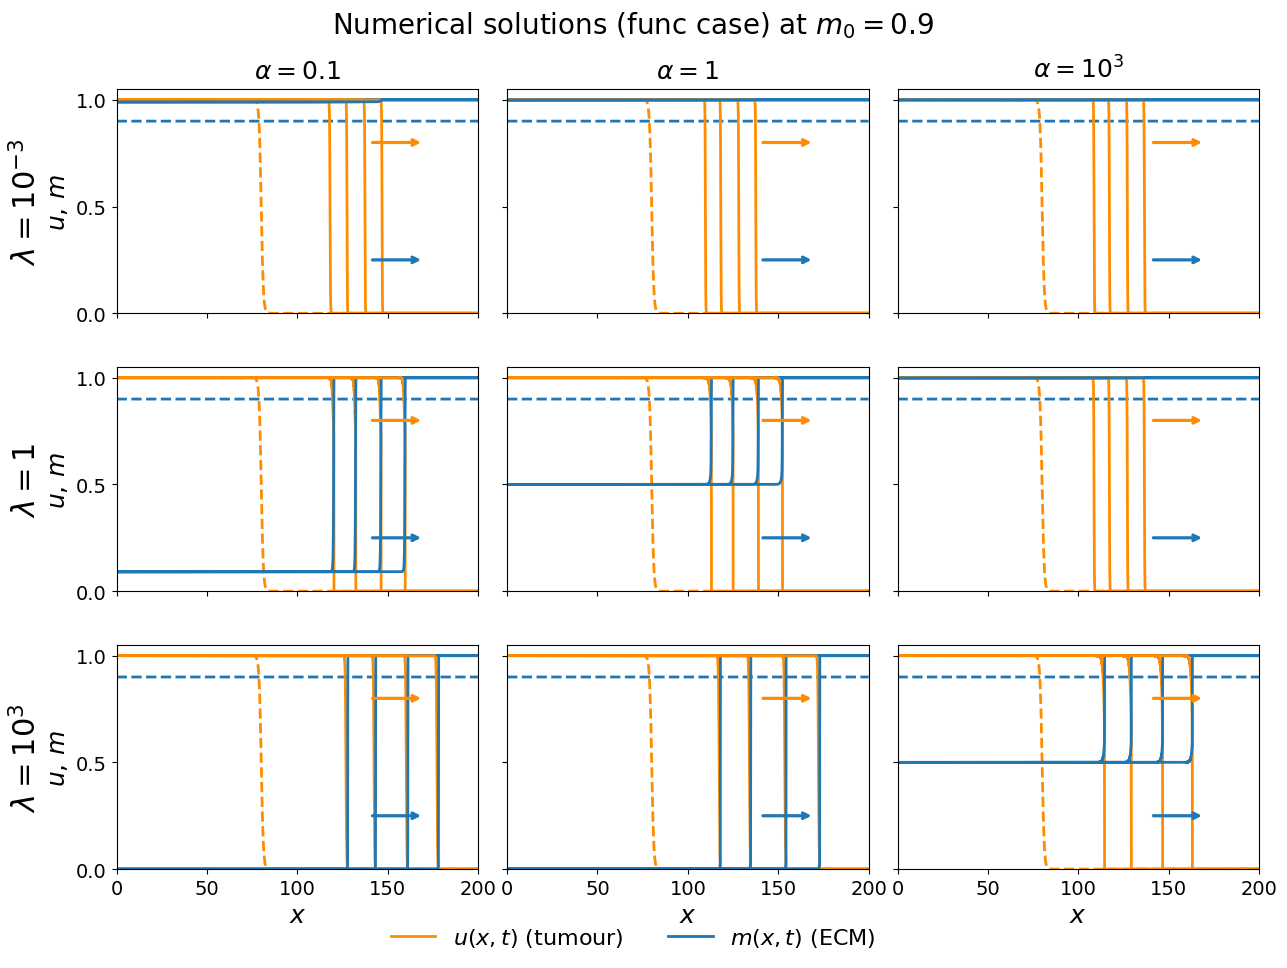

In [8]:
alpha_list = [1e-1, 1, 1e3]
lam_list   = [1e-3, 1, 1e3]
m0_fixed   = 0.9
models = build_models_from_speeds(alpha_list, lam_list, m0=m0_fixed, debug=True)
print("Loaded keys:", sorted(models.keys()))
plot_model_grid_alpha_lambda(
    models, alpha_list, lam_list,
    show_speed_text=False,
    m0=m0_fixed,
    t_points=[0,100, 200, 300, 400],
    color_scheme="opt2",
    save=True, out_path="Plots_Func/grid_m0_0p5"
)
plt.show()

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_single_run(models, alpha, lam, m0=0.5, 
                    t_points=(0,25,50,75,100),
                    color_scheme="opt1",
                    show_arrows=True,
                    show_speed_text=True,
                    figsize=(7,5)):
    """
    Plot u(x,t) and m(x,t) snapshots for one (alpha, lambda, m0).
    """
    m_color, u_color = _resolve_colors(color_scheme)
    key = (float(alpha), float(lam))
    mdl = models.get(key, None)
    if mdl is None:
        print(f"[warn] missing model for α={alpha}, λ={lam}, m0={m0}")
        return None

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(0, mdl.L)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r"$x$", fontsize=16)
    ax.set_ylabel(r"$u,\,m$", fontsize=16)

    t_indices = _nearest_indices(mdl.times, t_points)
    h_u = h_m = None
    for k,(tt,ti) in enumerate(zip(t_points,t_indices)):
        ls = '--' if k==0 else '-'
        h_u, = ax.plot(mdl.x, mdl.N_arr[ti], color=u_color, linestyle=ls, lw=2.0, label="u" if k==0 else "")
        h_m, = ax.plot(mdl.x, mdl.M_arr[ti], color=m_color, linestyle=ls, lw=2.0, label="m" if k==0 else "")

    if show_arrows:
        L = mdl.L
        ax.annotate('', xy=(0.85*L,0.8),  xytext=(0.70*L,0.8),
                    arrowprops=dict(arrowstyle='->', lw=2.3, color=u_color))
        ax.annotate('', xy=(0.85*L,0.25), xytext=(0.70*L,0.25),
                    arrowprops=dict(arrowstyle='->', lw=2.3, color=m_color))

    if show_speed_text:
        c = mdl.estimate_wave_speed(which="N")
        if np.isfinite(c):
            ax.text(0.03,0.86, rf"$c={c:.3g}$", transform=ax.transAxes,
                    fontsize=14, ha="left", va="top")

    ax.set_title(rf"$\alpha={_latex_sci(alpha)},\;\lambda={_latex_sci(lam)},\;m_0={m0}$")
    ax.legend(frameon=False)
    return fig, ax


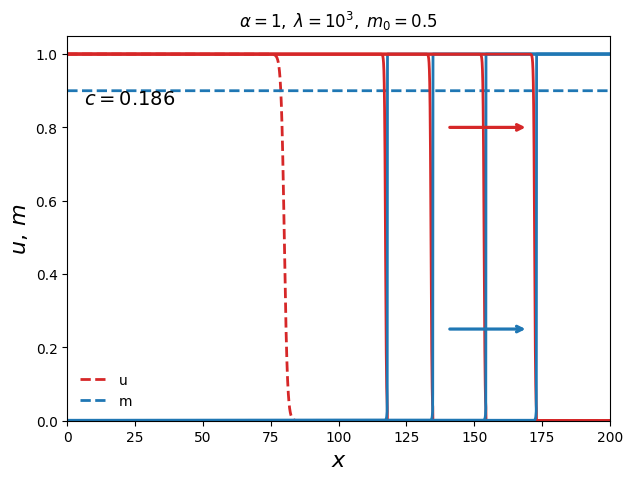

In [10]:
# assume you've already built models with build_models_from_speeds(...)
fig, ax = plot_single_run(models, alpha=1, lam=1000, m0=0.5,
                          t_points=[0,100, 200, 300, 400],
                          color_scheme="opt1")
plt.show()

In [11]:
# =========================
# 3×3 FUNC GRID FROM speeds_func_*  (m0 = 0.5)
# =========================
import os, glob, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ---------- your exact-speed merger (expects lambda_/alpha_/m0_ exact path) ----------
def _fmt_exact(v) -> str:
    v = float(v)
    if v.is_integer():
        return str(int(v))
    s = f"{v:.12f}".rstrip("0").rstrip(".")
    return "0" if s == "-0" else s

def _run_dir_exact(root, lam, alpha, m0):
    d = Path(root) / f"lambda_{_fmt_exact(lam)}" / f"alpha_{_fmt_exact(alpha)}" / f"m0_{_fmt_exact(m0)}"
    return d if d.is_dir() else None

def _slope_vs_time(t, xf, last_frac=0.5):
    t = np.asarray(t, float); xf = np.asarray(xf, float)
    if len(t) < 4 or len(xf) != len(t): return np.nan
    i0 = max(0, int((1.0 - last_frac) * len(t)))
    t_use = t[i0:]; x_use = xf[i0:]
    ok = np.isfinite(t_use) & np.isfinite(x_use)
    if ok.sum() < 3: return np.nan
    A = np.vstack([t_use[ok], np.ones(ok.sum())]).T
    slope, _ = np.linalg.lstsq(A, x_use[ok], rcond=None)[0]
    return float(slope)

def _speed_from_fronts_npz(npz_path):
    try: z = np.load(npz_path, allow_pickle=True)
    except Exception: return np.nan
    t = None; xf = None
    for tk in ("t","time","times","T"):
        if tk in z.files: t = z[tk]; break
    for fk in ("x_front","xfront","front","fronts","front_positions","xf"):
        if fk in z.files: xf = z[fk]; break
    if t is None or xf is None: return np.nan
    xf = np.asarray(xf)
    if xf.ndim > 1: xf = xf[..., -1].squeeze()
    return _slope_vs_time(t, xf, last_frac=0.5)

def _speed_from_summary_json(dirpath, which="N"):
    f = Path(dirpath) / "summary.json"
    if not f.is_file(): return np.nan
    try: obj = json.loads(f.read_text())
    except Exception: return np.nan
    w = str(which).upper()
    keys = ["speed","c","wave_speed"]
    if w == "N": keys = ["speed_N","c_N"] + keys
    if w == "M": keys = ["speed_M","c_M"] + keys
    for k in keys:
        if k in obj:
            try:
                val = float(obj[k])
                if np.isfinite(val): return val
            except Exception:
                pass
    return np.nan

def _speed_from_snapshots_npz(npz_path, threshold=0.5):
    try: z = np.load(npz_path, allow_pickle=True)
    except Exception: return np.nan
    x = z.get("x", z.get("X", None))
    u = z.get("N_arr", z.get("u_arr", z.get("N", None)))
    t = z.get("times", z.get("t", z.get("T", None)))
    if x is None or u is None or t is None: return np.nan
    x = np.asarray(x); t = np.asarray(t); U = np.asarray(u)
    if U.ndim != 2 or len(t) < 5: return np.nan
    i0 = len(t)//2
    t_use = t[i0:]; x_front = []
    for k in range(i0, len(t)):
        uk = U[k]
        idx = np.where((uk[:-1]-threshold)*(uk[1:]-threshold) <= 0)[0]
        if len(idx)==0: x_front.append(np.nan); continue
        j = idx[0]; xj,xj1 = x[j],x[j+1]; uj,uj1 = uk[j],uk[j+1]
        frac = 0.0 if uj1==uj else (threshold-uj)/(uj1-uj)
        x_front.append(xj + frac*(xj1-xj))
    return _slope_vs_time(t_use, np.asarray(x_front,float), last_frac=1.0)

def _load_speed(dirpath, which="N"):
    if dirpath is None or not Path(dirpath).is_dir(): return np.nan
    # 1) summary.json
    val = _speed_from_summary_json(dirpath, which=which)
    if np.isfinite(val): return val
    # 2) fronts (prefer which-specific)
    pr = []
    if str(which).upper()=="N": pr += ["fronts_N.npz","front_N.npz"]
    else:                        pr += ["fronts_M.npz","front_M.npz"]
    pr += ["fronts.npz","front.npz","front_positions.npz"]
    for name in pr:
        f = Path(dirpath)/name
        if f.is_file():
            val = _speed_from_fronts_npz(f)
            if np.isfinite(val): return val
    # 3) snapshots
    f = Path(dirpath)/"snapshots.npz"
    if f.is_file():
        val = _speed_from_snapshots_npz(f)
        if np.isfinite(val): return val
    return np.nan

def _merge_speed_from_roots(roots, lam, alpha, m0, which="N"):
    """Try each base_dir with EXACT path; first hit wins."""
    for root in roots:
        rd = _run_dir_exact(root, lam, alpha, m0)
        val = _load_speed(rd, which=which)
        if np.isfinite(val): return val
    return np.nan

# ---------- tolerant token generator for locating case dir & snapshots ----------
def _token_variants(v):
    v = float(v)
    dec = f"{v:.12f}".rstrip("0").rstrip(".")
    plain = f"{v:g}"
    sci = f"{v:.0e}"
    s,e = sci.split("e"); sci_neat = f"{s}e{int(e)}"
    outs = {dec, plain, sci, sci_neat}
    outs |= {s.replace(".","p") for s in list(outs)}  # allow 0p5, 1p0, etc.
    return outs

def _locate_case_dir(base_roots, lam, alpha, m0):
    """Locate existing dir under speeds_func_* using flexible tokens; returns Path or None."""
    lset = {f"lambda_{t}" for t in _token_variants(lam)}
    aset = {f"alpha_{t}"  for t in _token_variants(alpha)}
    mset = {f"m0_{t}"     for t in _token_variants(m0)}
    for root in base_roots:
        root = Path(root)
        for L in lset:
            for A in aset:
                for M in mset:
                    p = root / L / A / M
                    if p.is_dir():
                        return p
    return None

def _find_snapshots_npz(case_dir):
    """Prefer snapshots.npz, else snapshots_*.npz, else any .npz with 'snap' in the name."""
    d = Path(case_dir)
    cand = d/"snapshots.npz"
    if cand.is_file(): return cand
    hits = sorted(d.glob("snapshots_*.npz")) + sorted(d.glob("*snap*.npz"))
    return hits[0] if hits else None

# ---------- facade model built from speeds tree (snapshots.npz) ----------
class FacadeModel:
    def __init__(self, case_dir, alpha, lam, m0):
        snap = _find_snapshots_npz(case_dir)
        if snap is None:
            raise FileNotFoundError(f"No snapshots npz in {case_dir}")
        data = np.load(snap, allow_pickle=True)
        x = data.get("x", data.get("X"))
        u = data.get("N_arr", data.get("u_arr", data.get("N")))
        m = data.get("M_arr", data.get("m_arr", data.get("M")))
        t = data.get("times", data.get("t", data.get("T")))
        L = data.get("L", x[-1] if x is not None else None)
        if any(v is None for v in (x,u,m,t,L)):
            raise ValueError(f"Missing arrays in {snap}: has={list(data.files)}")
        self.x = np.asarray(x, float)
        self.N_arr = np.asarray(u, float)
        self.M_arr = np.asarray(m, float)
        self.times = np.asarray(t, float)
        self.L = float(L)
        self.alpha = float(alpha); self.lam = float(lam); self.m0 = float(m0)
        self.wave_speed = None
        self.case_dir = Path(case_dir)

    def estimate_wave_speed(self, which="N"):
        if self.wave_speed is None:
            # search u-then-l for m0>=0.5, else l-then-u
            roots = ("speeds_func_u","speeds_func_l") if self.m0 >= 0.5 else ("speeds_func_l","speeds_func_u")
            self.wave_speed = _merge_speed_from_roots(roots, self.lam, self.alpha, self.m0, which=which)
        return self.wave_speed

# ---------- presentation helpers ----------
def _latex_sci(v):
    v = float(v)
    if v == 0: return "0"
    if abs(v) >= 100 or abs(v) < 1e-2:
        k = int(np.round(np.log10(abs(v))))
        a = abs(v) / (10**k)
        if np.isclose(a, 1.0): return ("" if v>0 else "-") + rf"10^{{{k}}}"
        return ("" if v>0 else "-") + rf"{a:.2g}\times 10^{{{k}}}"
    return f"{v:g}"

def _nearest_indices(t_vec, t_points):
    t_vec = np.asarray(t_vec)
    return [int(np.argmin(np.abs(t_vec - t))) for t in t_points]

def _resolve_colors(s):
    if s == "opt1": return "#1f77b4", "#d62728"   # ECM blue, Tumour red
    if s == "opt2": return "#1f77b4", "#ff8c00"
    if s == "opt3": return "#6a00a8", "#ff8c00"
    return "#ff8c00", "#6a00a8"

# ---------- build models dict directly from speeds_func_* trees ----------
def build_models_from_speeds(alpha_list, lam_list, m0=0.5, debug=True):
    models = {}
    base_roots = ("speeds_func_u","speeds_func_l") if m0 >= 0.5 else ("speeds_func_l","speeds_func_u")
    missing = []
    for a in alpha_list:
        for l in lam_list:
            case = _locate_case_dir(base_roots, l, a, m0)
            if case is None:
                missing.append((a,l,"no dir")); continue
            snap = _find_snapshots_npz(case)
            if snap is None:
                missing.append((a,l,"no snapshots")); continue
            try:
                models[(float(a),float(l))] = FacadeModel(case, a, l, m0)
            except Exception as e:
                missing.append((a,l,f"bad npz: {e}"))
    if debug and missing:
        print("[warn] missing/bad cases:")
        for a,l,why in missing:
            print(f"  α={a:g}, λ={l:g}: {why}")
    return models

# ---------- grid plotter ----------
def plot_model_grid_alpha_lambda(
    models, alpha_list, lam_list,
    m0=0.5, t_points=(0,25,50,75,100),
    yticks_mode="basic", show_arrows=True, show_speed_text=True,
    color_scheme="opt1", figsize=(13.6,10.0),
    save=False, out_path="Plots_Func/grid_m0_0p5", dpi=600
):
    m_color, u_color = _resolve_colors(color_scheme)
    nrows, ncols = len(lam_list), len(alpha_list)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    fig.patch.set_facecolor("white")

    for j, a in enumerate(alpha_list):
        axes[0,j].set_title(rf"$\alpha={_latex_sci(a)}$", fontsize=18, pad=8)

    legend_handles = None
    for i, l in enumerate(lam_list):
        axes[i,0].text(-0.25,0.5, rf"$\lambda={_latex_sci(l)}$", transform=axes[i,0].transAxes,
                       ha="center", va="center", fontsize=22, fontweight="bold", rotation=90)
        shared_ylim = (0.0,1.05) if yticks_mode!="splitplus" else (0.0,1.25)
        yticks = {"basic":[0,0.5,1.0], "split":np.arange(0,1.01,0.2),
                  "splitplus":np.arange(0,1.21,0.2)}.get(yticks_mode,[0,0.5,1.0])

        for j, a in enumerate(alpha_list):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_ylim(shared_ylim); ax.set_yticks(yticks)
            if j>0: ax.set_yticklabels([])
            else:   ax.set_ylabel(r"$u,\,m$", fontsize=18)
            if i<nrows-1: ax.set_xticklabels([])

            mdl = models.get((float(a),float(l)))
            if mdl is None:
                ax.text(0.5,0.5,"missing run", transform=ax.transAxes, ha="center", va="center", fontsize=13)
                continue

            ax.set_xlim(0, mdl.L); ax.tick_params(axis='x',labelsize=14); ax.tick_params(axis='y',labelsize=14)
            t_idx = _nearest_indices(mdl.times, t_points)

            h_u = h_m = None
            for k,(tt,ti) in enumerate(zip(t_points,t_idx)):
                ls = '--' if k==0 else '-'
                h_u, = ax.plot(mdl.x, mdl.N_arr[ti], color=u_color, linestyle=ls, lw=2.0)
                h_m, = ax.plot(mdl.x, mdl.M_arr[ti], color=m_color, linestyle=ls, lw=2.0)
            if legend_handles is None and (h_u is not None) and (h_m is not None):
                legend_handles = [h_u, h_m]

            if show_arrows:
                L = mdl.L
                ax.annotate('', xy=(0.85*L,0.8),  xytext=(0.70*L,0.8),  arrowprops=dict(arrowstyle='->', lw=2.3, color=u_color))
                ax.annotate('', xy=(0.85*L,0.25), xytext=(0.70*L,0.25), arrowprops=dict(arrowstyle='->', lw=2.3, color=m_color))

            if show_speed_text:
                c = mdl.estimate_wave_speed(which="N")
                if np.isfinite(c):
                    ax.text(0.03,0.86, rf"$c={c:.3g}$", transform=ax.transAxes, fontsize=18, ha="left", va="top")

    for ax in axes[-1,:]: ax.set_xlabel(r"$x$", fontsize=18)
    fig.suptitle(rf"Numerical solutions (func case) at $m_0={m0}$", fontsize=20, y=0.98)
    plt.subplots_adjust(left=0.12, right=0.96, top=0.90, bottom=0.12, wspace=0.08, hspace=0.24)
    if legend_handles is not None:
        fig.legend(legend_handles, [r"$u(x,t)$ (tumour)", r"$m(x,t)$ (ECM)"],
                   loc="lower center", ncol=2, frameon=False, fontsize=16, bbox_to_anchor=(0.5,0.02))
    if save:
        os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
        plt.savefig(out_path + ".pdf", bbox_inches="tight")
        plt.savefig(out_path + ".png", dpi=dpi, bbox_inches="tight")
    return fig, axes

Loaded keys: [(0.1, 1000.0), (0.1, 1000000.0), (0.1, 100000000.0), (1.0, 1000.0), (1.0, 1000000.0), (1.0, 100000000.0), (1000.0, 1000.0), (1000.0, 1000000.0), (1000.0, 100000000.0)]


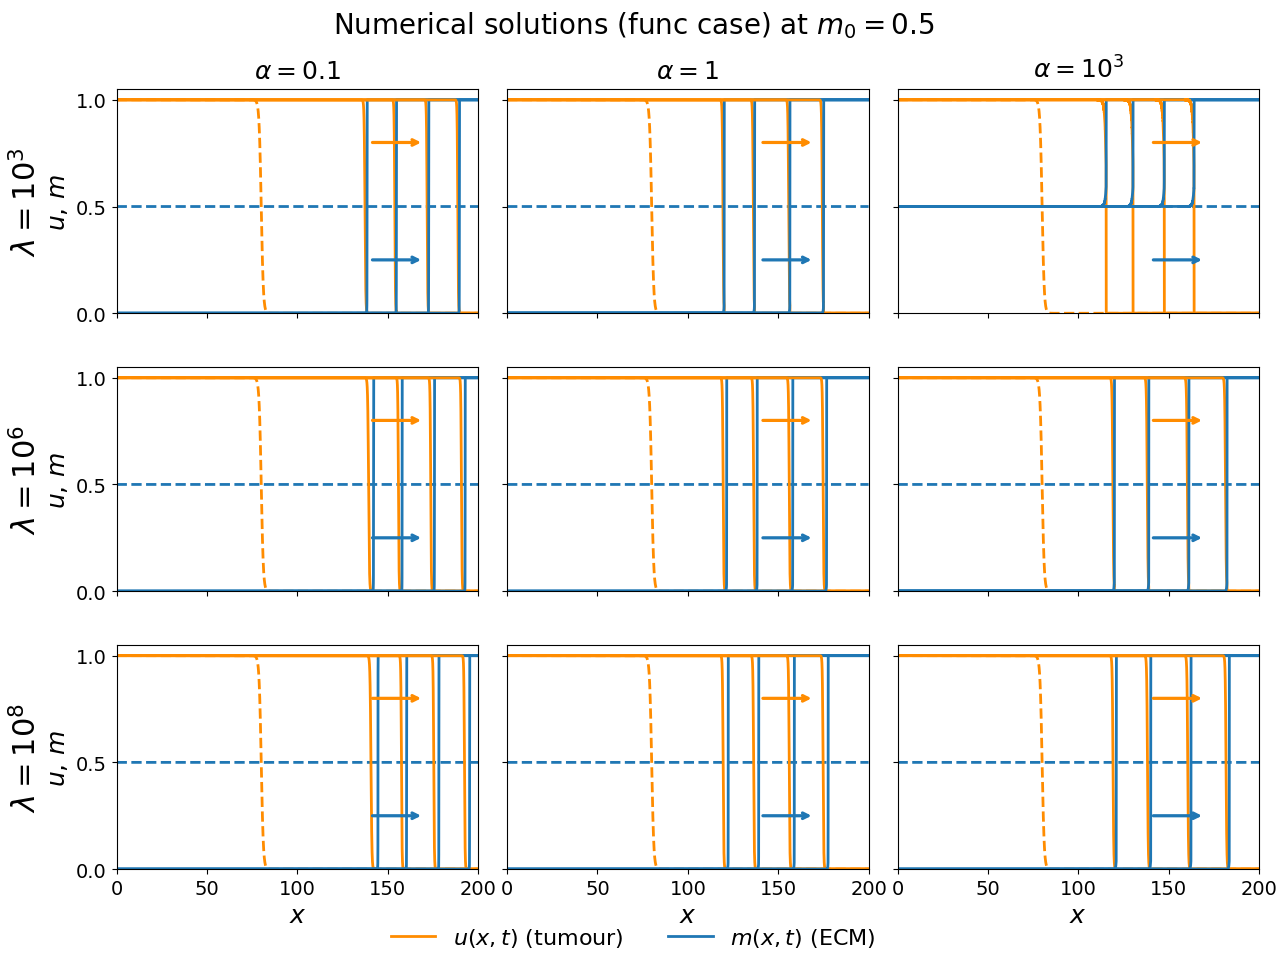

In [12]:
alpha_list = [1e-1, 1, 1e3]
lam_list   = [1e3, 1e6, 1e8]
m0_fixed   = 0.5
models = build_models_from_speeds(alpha_list, lam_list, m0=m0_fixed, debug=True)
print("Loaded keys:", sorted(models.keys()))
plot_model_grid_alpha_lambda(
    models, alpha_list, lam_list,
    m0=m0_fixed,
    t_points=[0, 100, 200, 300, 400],
    color_scheme="opt2",
    show_speed_text=False,
    save=True, out_path="Plots_Func/grid_m0_0p5")
plt.show()

Loaded keys: [(0.1, 0.001), (0.1, 1.0), (0.1, 1000.0), (1.0, 0.001), (1.0, 1.0), (1.0, 1000.0), (1000.0, 0.001), (1000.0, 1.0), (1000.0, 1000.0)]


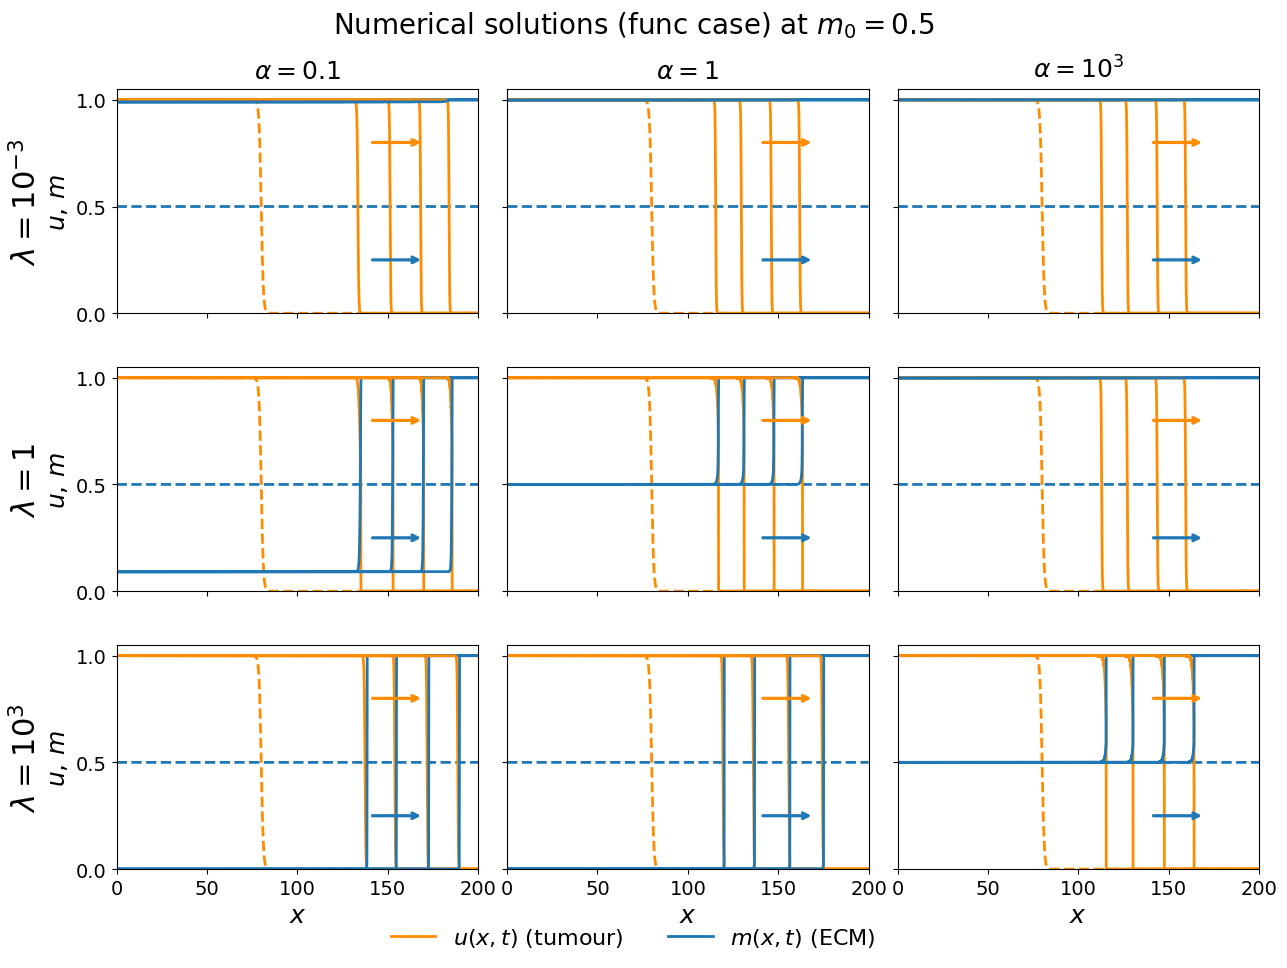

In [13]:
alpha_list = [1e-1, 1, 1e3]
lam_list   = [1e-3, 1, 1e3]
m0_fixed   = 0.5
models = build_models_from_speeds(alpha_list, lam_list, m0=m0_fixed, debug=True)
print("Loaded keys:", sorted(models.keys()))
plot_model_grid_alpha_lambda(
    models, alpha_list, lam_list,
    m0=m0_fixed,
    t_points=[0, 100, 200, 300, 400],
    color_scheme="opt2",
    show_speed_text=False,
    save=True, out_path="Plots_Func/grid_m0_0p5")
plt.show()

Loaded keys: [(10.0, 10.0), (10.0, 1000.0), (10.0, 100000.0), (10.0, 10000000.0), (1000.0, 10.0), (1000.0, 1000.0), (1000.0, 100000.0), (1000.0, 10000000.0), (100000.0, 10.0), (100000.0, 1000.0), (100000.0, 100000.0), (100000.0, 10000000.0), (10000000.0, 10.0), (10000000.0, 1000.0), (10000000.0, 100000.0), (10000000.0, 10000000.0)]


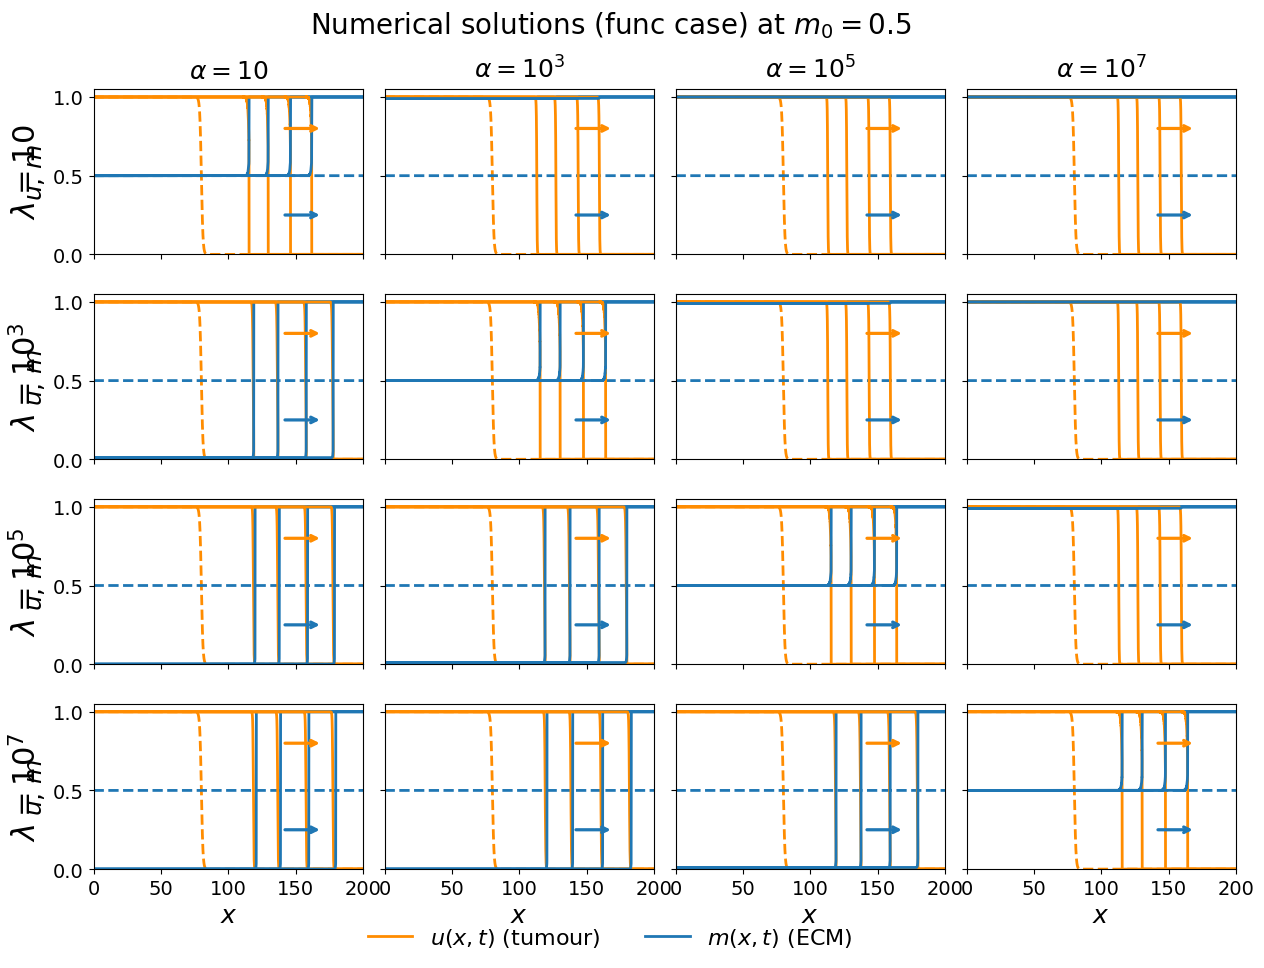

In [14]:
alpha_list = [10, 1e3, 1e5, 1e7]
lam_list   = [10, 1e3, 1e5, 1e7]
m0_fixed   = 0.5
models = build_models_from_speeds(alpha_list, lam_list, m0=m0_fixed, debug=True)
print("Loaded keys:", sorted(models.keys()))
plot_model_grid_alpha_lambda(
    models, alpha_list, lam_list,
    m0=m0_fixed,
    t_points=[0, 100, 200, 300, 400],
    color_scheme="opt2",
    show_speed_text=False,
    save=True, out_path="Plots_Func/grid_m0_0p5")
plt.show()

Loaded keys: [(10.0, 10.0), (10.0, 1000.0), (10.0, 100000.0), (10.0, 10000000.0), (1000.0, 10.0), (1000.0, 1000.0), (1000.0, 100000.0), (1000.0, 10000000.0), (100000.0, 10.0), (100000.0, 1000.0), (100000.0, 100000.0), (100000.0, 10000000.0), (10000000.0, 10.0), (10000000.0, 1000.0), (10000000.0, 100000.0), (10000000.0, 10000000.0)]


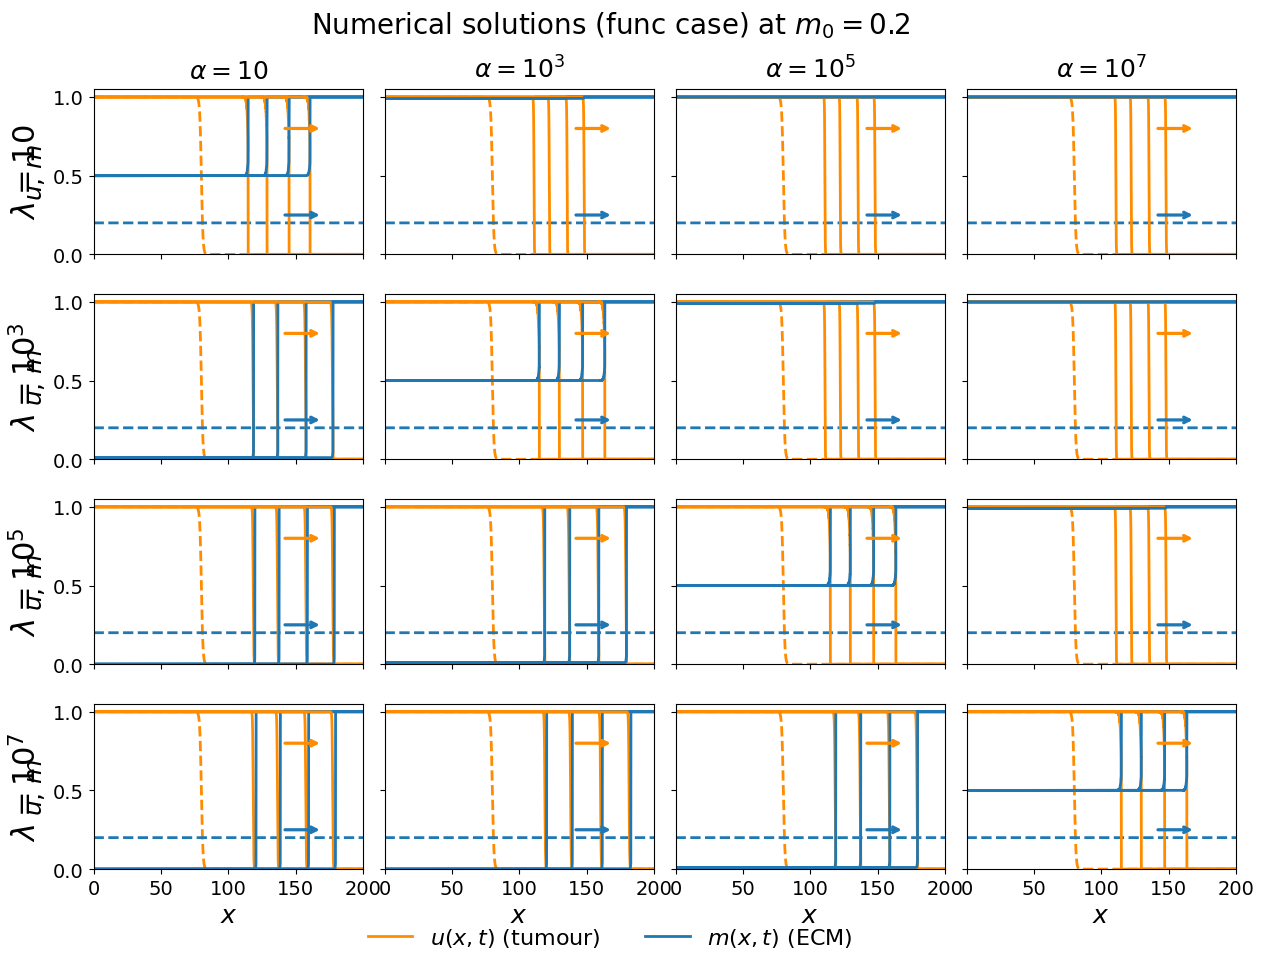

In [22]:
alpha_list = [10, 1e3, 1e5, 1e7]
lam_list   = [10, 1e3, 1e5, 1e7]
m0_fixed   = 0.2
models = build_models_from_speeds(alpha_list, lam_list, m0=m0_fixed, debug=True)
print("Loaded keys:", sorted(models.keys()))
plot_model_grid_alpha_lambda(
    models, alpha_list, lam_list,
    m0=m0_fixed,
    t_points=[0, 100, 200, 300, 400],
    color_scheme="opt2",
    show_speed_text=False,
    save=True, out_path="Plots_Func/grid_m0_0p5")
plt.show()

[warn] missing/bad cases:
  α=100000, λ=10: no snapshots
  α=1e+07, λ=10: no snapshots
  α=1e+07, λ=1000: no snapshots
Loaded keys: [(10.0, 10.0), (10.0, 1000.0), (10.0, 100000.0), (10.0, 10000000.0), (1000.0, 10.0), (1000.0, 1000.0), (1000.0, 100000.0), (1000.0, 10000000.0), (100000.0, 1000.0), (100000.0, 100000.0), (100000.0, 10000000.0), (10000000.0, 100000.0), (10000000.0, 10000000.0)]


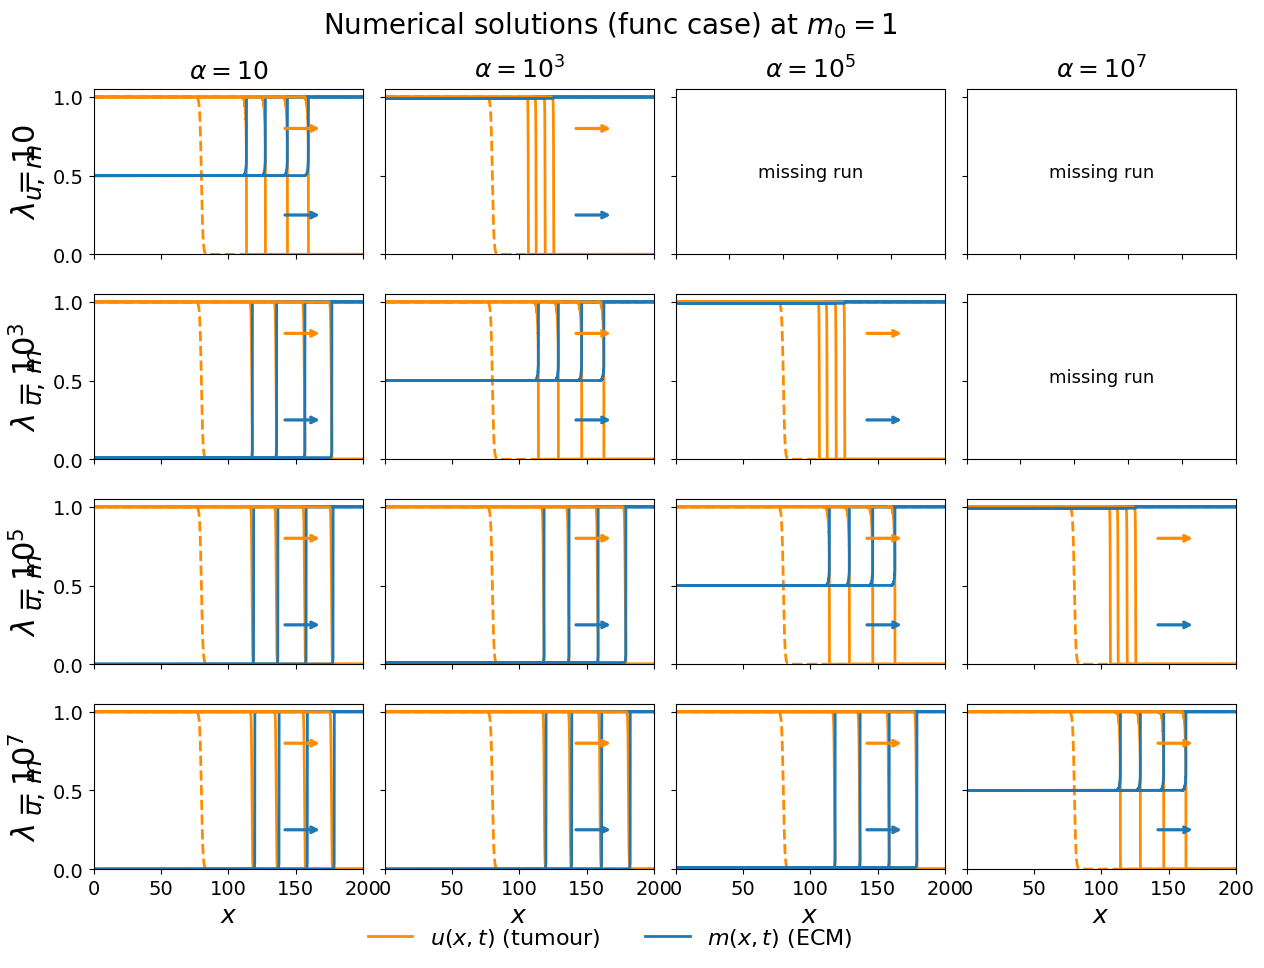

In [15]:
alpha_list = [10, 1e3, 1e5, 1e7]
lam_list   = [10, 1e3, 1e5, 1e7]
m0_fixed   = 1
models = build_models_from_speeds(alpha_list, lam_list, m0=m0_fixed, debug=True)
print("Loaded keys:", sorted(models.keys()))
plot_model_grid_alpha_lambda(
    models, alpha_list, lam_list,
    m0=m0_fixed,
    t_points=[0, 100, 200, 300, 400],
    color_scheme="opt2",
    show_speed_text=False,
    save=True, out_path="Plots_Func/grid_m0_0p5")
plt.show()

[warn] missing/bad cases:
  α=100000, λ=10: no snapshots
  α=1e+07, λ=10: no snapshots
  α=1e+07, λ=1000: no snapshots
Loaded keys: [(10.0, 10.0), (10.0, 1000.0), (10.0, 100000.0), (10.0, 10000000.0), (1000.0, 10.0), (1000.0, 1000.0), (1000.0, 100000.0), (1000.0, 10000000.0), (100000.0, 1000.0), (100000.0, 100000.0), (100000.0, 10000000.0), (10000000.0, 100000.0), (10000000.0, 10000000.0)]


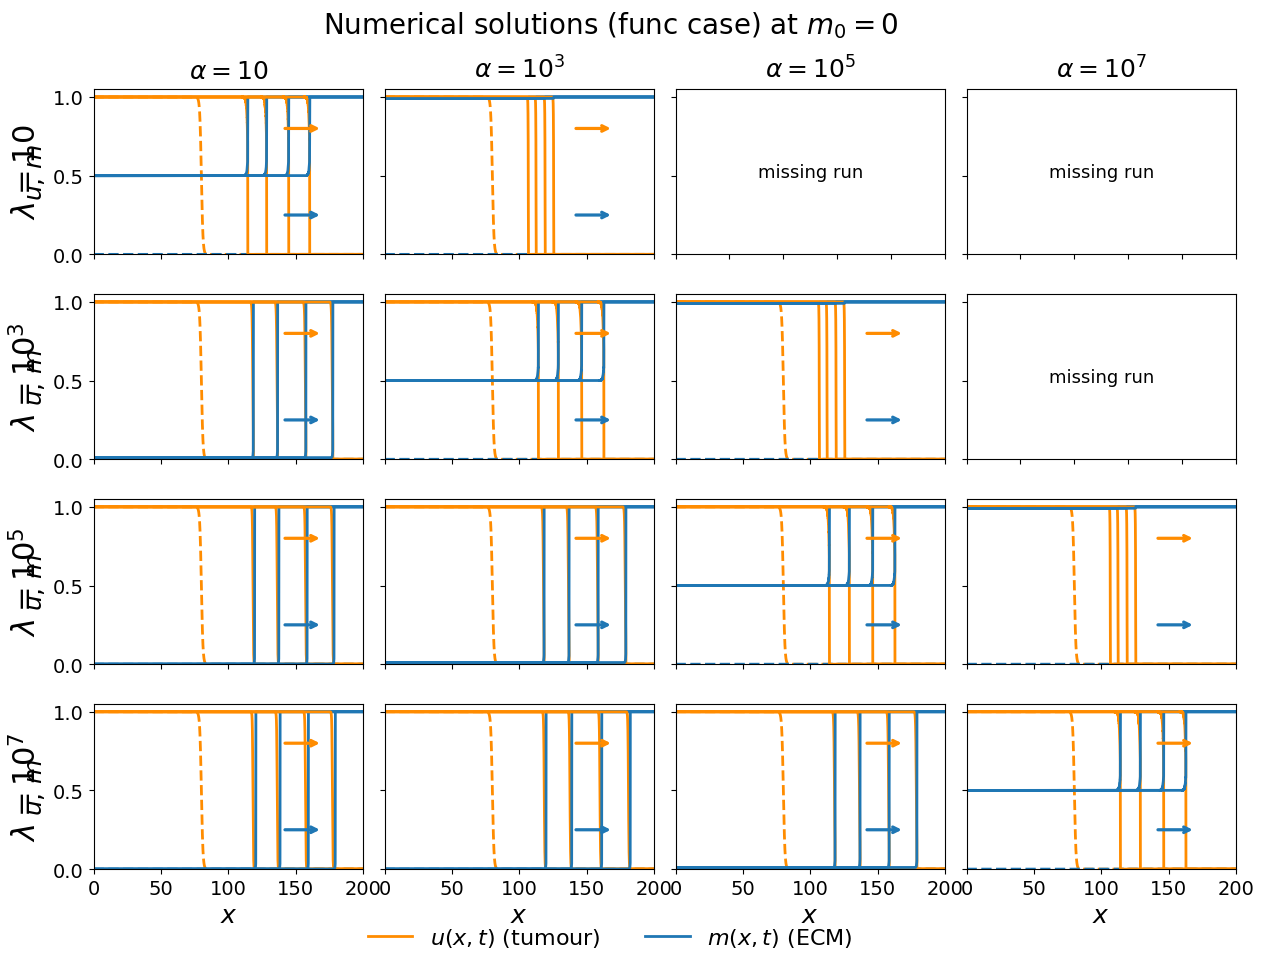

In [16]:
alpha_list = [10, 1e3, 1e5, 1e7]
lam_list   = [10, 1e3, 1e5, 1e7]
m0_fixed   = 0
models = build_models_from_speeds(alpha_list, lam_list, m0=m0_fixed, debug=True)
print("Loaded keys:", sorted(models.keys()))
plot_model_grid_alpha_lambda(
    models, alpha_list, lam_list,
    m0=m0_fixed,
    t_points=[0, 100, 200, 300, 400],
    color_scheme="opt2",
    show_speed_text=False,
    save=True, out_path="Plots_Func/grid_m0_0p5")
plt.show()

In [17]:
import os, glob, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ---------- tolerant folder tokens (0.001 / 1e-3 / 0p5) ----------
def _token_variants(v):
    v = float(v)
    dec = f"{v:.12f}".rstrip("0").rstrip(".")
    plain = f"{v:g}"
    sci = f"{v:.0e}"; s,e = sci.split("e"); sci_neat = f"{s}e{int(e)}"
    outs = {dec, plain, sci, sci_neat}
    outs |= {s.replace(".","p") for s in list(outs)}  # allow 0p5 style
    return outs

def _locate_case_dir(base_roots, lam, alpha, m0):
    lset = {f"lambda_{t}" for t in _token_variants(lam)}
    aset = {f"alpha_{t}"  for t in _token_variants(alpha)}
    mset = {f"m0_{t}"     for t in _token_variants(m0)}
    for root in base_roots:
        root = Path(root)
        for L in lset:
            for A in aset:
                for M in mset:
                    p = root / L / A / M
                    if p.is_dir():
                        return p
    return None

def _find_snapshots_npz(case_dir):
    d = Path(case_dir)
    cand = d / "snapshots.npz"
    if cand.is_file():
        return cand
    hits = sorted(d.glob("snapshots_*.npz")) + sorted(d.glob("*snap*.npz"))
    return hits[0] if hits else None

# ---------- lean model wrapper used by the plots ----------
class _Model:
    def __init__(self, npz_path, alpha, lam, m0):
        z = np.load(npz_path, allow_pickle=True)
        x = z.get("x", z.get("X"))
        U = z.get("N_arr", z.get("u_arr", z.get("N")))
        M = z.get("M_arr", z.get("m_arr", z.get("M")))
        t = z.get("times", z.get("t", z.get("T")))
        L = z.get("L", x[-1] if x is not None else None)
        if any(v is None for v in (x,U,M,t,L)):
            raise ValueError(f"missing arrays in {npz_path}; has {list(z.files)}")
        self.x = np.asarray(x, float)
        self.N_arr = np.asarray(U, float)
        self.M_arr = np.asarray(M, float)
        self.times = np.asarray(t, float)
        self.L = float(L)
        self.alpha = float(alpha)
        self.lam = float(lam)
        self.m0 = float(m0)

# ---------- factory: returns a models_dict_fn() (no args) ----------
def make_models_dict_fn(alpha, m0=0.5, roots=None, verbose=True):
    """
    Returns a zero-arg function that builds {lambda: _Model} from speeds_func_* trees.
    If roots is None, pick order based on m0 (u first for m0≥0.5).
    """
    if roots is None:
        roots = ("speeds_func_u","speeds_func_l") if m0 >= 0.5 else ("speeds_func_l","speeds_func_u")
    roots = tuple(roots)

    def _models_dict_fn():
        models = {}
        # Discover all available lambdas across the roots
        lambdas_found = set()
        for r in roots:
            base = Path(r)
            if not base.is_dir():
                continue
            for lam_dir in base.glob("lambda_*"):
                try:
                    # parse lambda value from folder name after "lambda_"
                    lam_str = lam_dir.name.split("lambda_",1)[1]
                    # undo 0p5 style for parsing
                    lam_val = float(lam_str.replace("p","."))
                    lambdas_found.add(lam_val)
                except Exception:
                    continue

        # For each lambda, try to locate the exact case dir and load snapshots
        missing = []
        for lam in sorted(lambdas_found):
            case = _locate_case_dir(roots, lam, alpha, m0)
            if case is None:
                missing.append((lam, "no dir")); continue
            snap = _find_snapshots_npz(case)
            if snap is None:
                missing.append((lam, "no snapshots")); continue
            try:
                models[float(lam)] = _Model(snap, alpha, lam, m0)
            except Exception as e:
                missing.append((lam, f"bad npz: {e}"))
        if verbose and missing:
            print("[warn] some λ not loadable:")
            for lam, why in missing:
                print(f"  λ={lam:g}: {why}")
        return models

    return _models_dict_fn

# ---------- your plotting function (u+m and 1-(u+m) with λ colormap) ----------
def plot_um_and_gap_colormap(
    models_dict_fn,
    lam_list=(1e1,1e2,1e3,1e4,1e5,1e6,1e7,1e8),
    t_points=(0, 50, 100),
    cmap="plasma",
    lw=2.2,
    figsize=(13, 5.8),
    ylim_sum=(-0.05, 1.6),
    ylim_gap=(-0.05, 1.05),
    big_fonts=True,
    show_time_styles=True,
    save=False, out_prefix="Plots_Plain/m05_um_gap_colormap"
):
    """
    Single-panel plots for u+m and 1-(u+m) across many λ, coloured by log10(λ).
    Expects models_dict_fn() -> dict {lambda: model} where model has x, N_arr, M_arr, times.
    """
    # Load every available model; we'll index the requested lam_list below.
    models_all = models_dict_fn()
    lam_list = list(lam_list)

    # quick check
    missing = [lam for lam in lam_list if float(lam) not in models_all]
    if missing:
        print("[info] some requested λ not found, they’ll be skipped:", [f"{m:g}" for m in missing])

    # Normalise λ for colormap
    lam_for_cmap = np.asarray(lam_list, dtype=float)
    log_lam = np.log10(lam_for_cmap)
    norm = plt.Normalize(vmin=np.nanmin(log_lam), vmax=np.nanmax(log_lam))
    smap = cm.ScalarMappable(norm=norm, cmap=cmap)

    # Fonts
    if big_fonts:
        title_fs = 22; label_fs = 18; tick_fs = 14; cbar_fs = 16
    else:
        title_fs = 18; label_fs = 14; tick_fs = 12; cbar_fs = 12

    # time→linestyle mapping
    if show_time_styles:
        ls_cycle = ["--", "-.", "-"]
        linestyles = [ls_cycle[i % len(ls_cycle)] for i in range(len(t_points))]
    else:
        linestyles = ["-"] * len(t_points)

    # ---------- Figure 1: u+m ----------
    fig1, ax1 = plt.subplots(figsize=figsize)
    for lam in lam_list:
        key = float(lam)
        if key not in models_all:  # skip missing
            continue
        mdl = models_all[key]
        x, t, U, M = mdl.x, mdl.times, mdl.N_arr, mdl.M_arr
        tids = [int(np.argmin(np.abs(t - tp))) for tp in t_points]
        color = smap.to_rgba(np.log10(float(lam)))
        for ls, tidx in zip(linestyles, tids):
            ax1.plot(x, U[tidx] + M[tidx], color=color, lw=lw, linestyle=ls)

    ax1.set_title(r"$u+m$ profiles  (fixed $m_0=0.5$)", fontsize=title_fs)
    ax1.set_xlabel(r"$x$", fontsize=label_fs)
    ax1.set_ylabel("Numerically estimated sum  $u+m$", fontsize=label_fs)
    ax1.set_ylim(*ylim_sum)
    ax1.tick_params(axis='both', labelsize=tick_fs)
    cbar1 = fig1.colorbar(smap, ax=ax1)
    cbar1.set_label(r"$\log_{10}(\lambda)$", fontsize=label_fs)
    cbar1.ax.tick_params(labelsize=cbar_fs)
    fig1.tight_layout()

    if save:
        fig1.savefig(out_prefix + "_sum.png", dpi=300, bbox_inches="tight")
        fig1.savefig(out_prefix + "_sum.pdf", bbox_inches="tight")

    # ---------- Figure 2: 1-(u+m) ----------
    fig2, ax2 = plt.subplots(figsize=figsize)
    for lam in lam_list:
        key = float(lam)
        if key not in models_all:
            continue
        mdl = models_all[key]
        x, t, U, M = mdl.x, mdl.times, mdl.N_arr, mdl.M_arr
        tids = [int(np.argmin(np.abs(t - tp))) for tp in t_points]
        color = smap.to_rgba(np.log10(float(lam)))
        for ls, tidx in zip(linestyles, tids):
            ax2.plot(x, 1.0 - (U[tidx] + M[tidx]), color=color, lw=lw, linestyle=ls)

    ax2.set_title(r"$1-(u+m)$ profiles  (fixed $m_0=0.5$)", fontsize=title_fs)
    ax2.set_xlabel(r"$x$", fontsize=label_fs)
    ax2.set_ylabel(r"Free space $1-(u+m)$", fontsize=label_fs)
    ax2.set_ylim(*ylim_gap)
    ax2.tick_params(axis='both', labelsize=tick_fs)
    cbar2 = fig2.colorbar(smap, ax=ax2)
    cbar2.set_label(r"$\log_{10}(\lambda)$", fontsize=label_fs)
    cbar2.ax.tick_params(labelsize=cbar_fs)
    fig2.tight_layout()

    if save:
        fig2.savefig(out_prefix + "_gap.png", dpi=300, bbox_inches="tight")
        fig2.savefig(out_prefix + "_gap.pdf", bbox_inches="tight")

    return fig1, fig2

In [18]:
def plot_um_and_gap_colormap(
    models_dict_fn,
    lam_list=(1e1,1e2,1e3,1e4,1e5,1e6,1e7,1e8),
    t_points=(0, 50, 100),
    cmap="plasma",
    lw=2.2,
    figsize=(13, 5.8),
    ylim_sum=(-0.05, 1.6),
    ylim_gap=(-0.05, 1.05),
    big_fonts=True,
    save=False, out_prefix="Plots_Plain/m05_um_gap_colormap"
):
    """
    Single-panel plots for u+m and 1-(u+m) across many λ, coloured by log10(λ).
    Expects models_dict_fn() -> dict {lambda: model} where model has x, N_arr, M_arr, times.
    """
    models_all = models_dict_fn()
    lam_list = list(lam_list)

    # skip missing λ gracefully
    missing = [lam for lam in lam_list if float(lam) not in models_all]
    if missing:
        print("[info] some requested λ not found, skipped:", [f"{m:g}" for m in missing])

    # Normalise λ for colormap
    lam_for_cmap = np.asarray(lam_list, dtype=float)
    log_lam = np.log10(lam_for_cmap)
    norm = plt.Normalize(vmin=np.nanmin(log_lam), vmax=np.nanmax(log_lam))
    smap = cm.ScalarMappable(norm=norm, cmap=cmap)

    # Fonts
    if big_fonts:
        title_fs = 22; label_fs = 18; tick_fs = 14; cbar_fs = 16
    else:
        title_fs = 18; label_fs = 14; tick_fs = 12; cbar_fs = 12

    # --- all times solid lines ---
    linestyles = ["-"] * len(t_points)

    # ---------- Figure 1: u+m ----------
    fig1, ax1 = plt.subplots(figsize=figsize)
    for lam in lam_list:
        key = float(lam)
        if key not in models_all: continue
        mdl = models_all[key]
        x, t, U, M = mdl.x, mdl.times, mdl.N_arr, mdl.M_arr
        tids = [int(np.argmin(np.abs(t - tp))) for tp in t_points]
        color = smap.to_rgba(np.log10(float(lam)))
        for ls, tidx in zip(linestyles, tids):
            ax1.plot(x, U[tidx] + M[tidx], color=color, lw=lw, linestyle=ls)

    ax1.set_title(r"$u+m$ profiles  (fixed $m_0=0.5$)", fontsize=title_fs)
    ax1.set_xlabel(r"$x$", fontsize=label_fs)
    ax1.set_ylabel("Numerically estimated sum  $u+m$", fontsize=label_fs)
    ax1.set_ylim(*ylim_sum)
    ax1.tick_params(axis='both', labelsize=tick_fs)
    cbar1 = fig1.colorbar(smap, ax=ax1)
    cbar1.set_label(r"$\log_{10}(\lambda)$", fontsize=label_fs)
    cbar1.ax.tick_params(labelsize=cbar_fs)
    fig1.tight_layout()

    if save:
        os.makedirs(os.path.dirname(out_prefix) or ".", exist_ok=True)
        fig1.savefig(out_prefix + "_sum.png", dpi=300, bbox_inches="tight")
        fig1.savefig(out_prefix + "_sum.pdf", dpi=300, bbox_inches="tight")

    # ---------- Figure 2: 1-(u+m) ----------
    fig2, ax2 = plt.subplots(figsize=figsize)
    for lam in lam_list:
        key = float(lam)
        if key not in models_all: continue
        mdl = models_all[key]
        x, t, U, M = mdl.x, mdl.times, mdl.N_arr, mdl.M_arr
        tids = [int(np.argmin(np.abs(t - tp))) for tp in t_points]
        color = smap.to_rgba(np.log10(float(lam)))
        for ls, tidx in zip(linestyles, tids):
            ax2.plot(x, 1.0 - (U[tidx] + M[tidx]), color=color, lw=lw, linestyle=ls)

    ax2.set_title(r"$1-(u+m)$ profiles  (fixed $m_0=0.5$)", fontsize=title_fs)
    ax2.set_xlabel(r"$x$", fontsize=label_fs)
    ax2.set_ylabel(r"Free space $1-(u+m)$", fontsize=label_fs)
    ax2.set_ylim(*ylim_gap)
    ax2.tick_params(axis='both', labelsize=tick_fs)
    cbar2 = fig2.colorbar(smap, ax=ax2)
    cbar2.set_label(r"$\log_{10}(\lambda)$", fontsize=label_fs)
    cbar2.ax.tick_params(labelsize=cbar_fs)
    fig2.tight_layout()

    if save:
        os.makedirs(os.path.dirname(out_prefix) or ".", exist_ok=True)
        fig2.savefig(out_prefix + "_gap.png", dpi=300, bbox_inches="tight")
        fig2.savefig(out_prefix + "_gap.pdf", dpi=300, bbox_inches="tight")

    return fig1, fig2

[warn] some λ not loadable:
  λ=0.001: no snapshots
[info] some requested λ not found, skipped: ['10000']


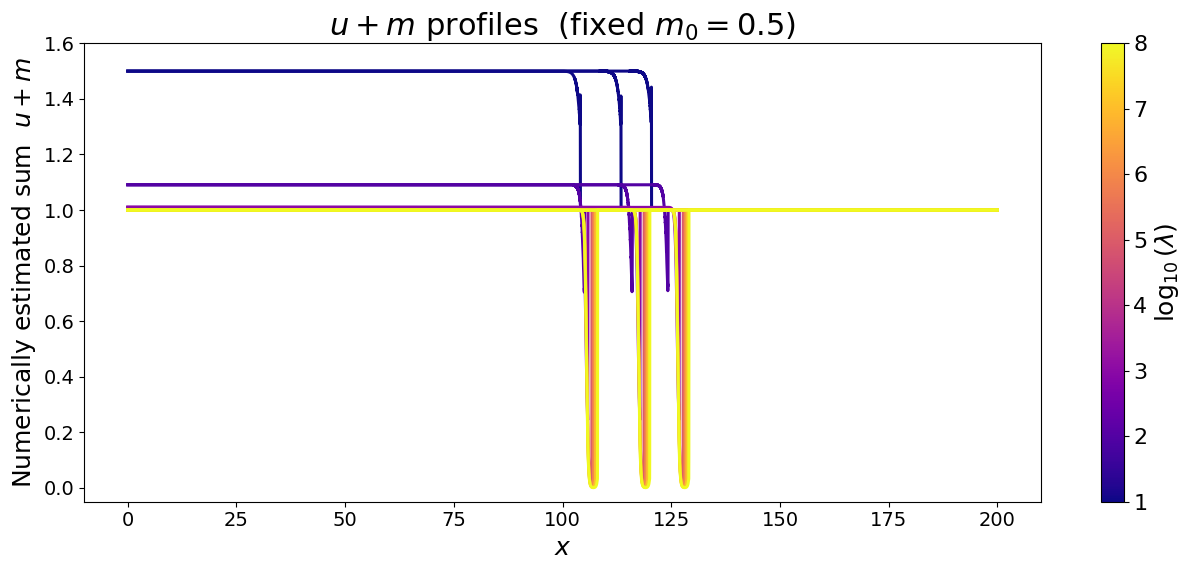

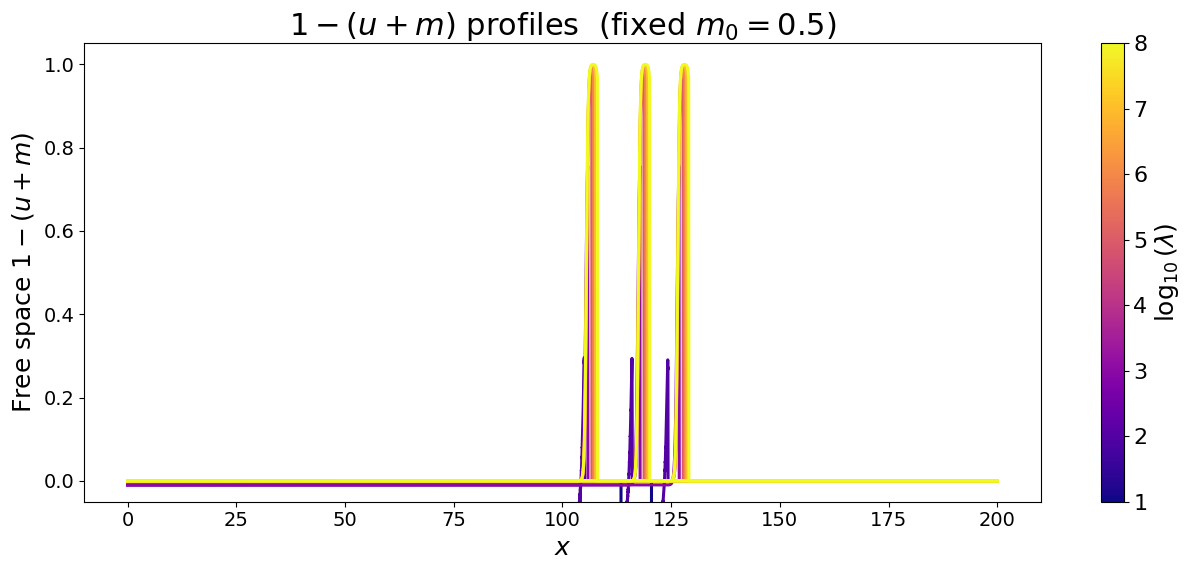

In [19]:
# Build a dict fn at α = 0.1, m0 = 0.5 (searches speeds_func_u first)
models_dict_fn = make_models_dict_fn(alpha=10, m0=1, roots=("speeds_func_u","speeds_func_l"))

# Choose the λ range you want coloured
lam_list = (1e1,1e2,1e3,1e4,1e5,1e6,1e7,1e8)

# Plot both panels
plot_um_and_gap_colormap(
    models_dict_fn,
    lam_list=lam_list,
    t_points=(50,100, 150),
    cmap="plasma",
    save=True,
    out_prefix="Plots_Plain/m05_um_gap_colormap"
)
plt.show()

In [20]:
import os, glob
from pathlib import Path
import numpy as np

def _token_variants(v):
    v = float(v)
    dec = f"{v:.12f}".rstrip("0").rstrip(".")
    plain = f"{v:g}"
    sci = f"{v:.0e}"
    s,e = sci.split("e")
    sci_neat = f"{s}e{int(e)}"         # '1e+04' -> '1e4'
    toks = {dec, plain, sci, sci_neat}
    toks |= {t.replace(".", "p") for t in list(toks)}  # allow 0p5 etc.
    return toks

def _locate_case_dir(base_roots, lam, alpha, m0):
    lset = {f"lambda_{t}" for t in _token_variants(lam)}
    aset = {f"alpha_{t}"  for t in _token_variants(alpha)}
    mset = {f"m0_{t}"     for t in _token_variants(m0)}
    for root in base_roots:
        r = Path(root)
        for L in lset:
            ld = r / L
            if not ld.is_dir(): continue
            for A in aset:
                ad = ld / A
                if not ad.is_dir(): continue
                for M in mset:
                    md = ad / M
                    if md.is_dir(): return md
    return None

def _find_snapshots_npz_loose(case_dir: Path):
    """
    Prefer 'snapshots*.npz' if present; else accept ANY .npz in case_dir
    that contains x & (N/u) & (M/m) & times keys.
    """
    case_dir = Path(case_dir)
    # 1) preferred names
    for pat in ("snapshots.npz", "snapshots_*.npz", "*snap*.npz"):
        for f in sorted(case_dir.glob(pat)):
            try:
                z = np.load(f, allow_pickle=True)
                if {'x'} & set(z.files) and ({'N_arr','u_arr','N'} & set(z.files)) \
                   and ({'M_arr','m_arr','M'} & set(z.files)) \
                   and ({'times','t','T'} & set(z.files)):
                    return f
            except Exception:
                pass
    # 2) any .npz that has the required arrays
    for f in sorted(case_dir.glob("*.npz")):
        try:
            z = np.load(f, allow_pickle=True)
            if {'x'} & set(z.files) and ({'N_arr','u_arr','N'} & set(z.files)) \
               and ({'M_arr','m_arr','M'} & set(z.files)) \
               and ({'times','t','T'} & set(z.files)):
                return f
        except Exception:
            pass
    return None

class _Model:
    def __init__(self, npz_path, alpha, lam, m0):
        z = np.load(npz_path, allow_pickle=True)
        x = z.get("x", z.get("X"))
        U = z.get("N_arr", z.get("u_arr", z.get("N")))
        M = z.get("M_arr", z.get("m_arr", z.get("M")))
        t = z.get("times", z.get("t", z.get("T")))
        L = z.get("L", x[-1] if x is not None else None)
        if any(v is None for v in (x,U,M,t,L)):
            raise ValueError(f"missing arrays in {npz_path}; has {list(z.files)}")
        self.x = np.asarray(x, float)
        self.N_arr = np.asarray(U, float)
        self.M_arr = np.asarray(M, float)
        self.times = np.asarray(t, float)
        self.L = float(L)
        self.alpha = float(alpha)
        self.lam = float(lam)
        self.m0 = float(m0)

def make_models_dict_fn(alpha, m0=0.5, roots=None, verbose=True):
    """
    Returns models_dict_fn() -> {lambda: _Model}.
    Auto-prepends 'speeds_func_4' if it exists. Searches all roots.
    """
    # pick default family order by m0; then auto-prepend patch folder
    if roots is None:
        roots = ("speeds_func_u","speeds_func_l") if m0 >= 0.5 else ("speeds_func_l","speeds_func_u")
    roots = list(roots)
    if os.path.isdir("speeds_func_4"):
        roots = ["speeds_func_4"] + roots
    # de-dup keep order
    seen, ordered_roots = set(), []
    for r in roots:
        if r not in seen:
            seen.add(r); ordered_roots.append(r)
    roots = tuple(ordered_roots)

    def _models_dict_fn():
        models = {}
        lambdas_found = set()
        # discover all lambda_* across all roots (includes 1e4 variants)
        for r in roots:
            base = Path(r)
            if not base.is_dir(): continue
            for lam_dir in base.glob("lambda_*"):
                name = lam_dir.name.split("lambda_",1)[1]
                try:
                    lam_val = float(name.replace("p","."))  # supports 0p1, 1e4, 1e+04, etc.
                    lambdas_found.add(lam_val)
                except Exception:
                    continue

        missing = []
        for lam in sorted(lambdas_found):
            case = _locate_case_dir(roots, lam, alpha, m0)
            if case is None:
                missing.append((lam, "no dir")); continue
            snap = _find_snapshots_npz_loose(case)
            if snap is None:
                missing.append((lam, "no snapshots")); continue
            try:
                models[float(lam)] = _Model(snap, alpha, lam, m0)
            except Exception as e:
                missing.append((lam, f"bad npz: {e}"))
        if verbose and missing:
            print("[warn] some λ not loadable:")
            for lam, why in missing:
                print(f"  λ={lam:g}: {why}")
        return models

    return _models_dict_fn

In [21]:
import matplotlib.pyplot as plt

models_dict_fn = make_models_dict_fn(
    alpha=10,
    m0=1.0,
    roots=("speeds_func_u", "speeds_func_l")  # 'speeds_func_4' auto-prepended if present
)

#lam_list = (1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8)
lam_list = (1e4)
plot_um_and_gap_colormap(
    models_dict_fn,
    lam_list=lam_list,
    t_points=(50, 100, 150),
    cmap="plasma",
    save=True,
    
    out_prefix="Plots_Plain/m05_um_gap_colormap"
)

plt.show()

[warn] some λ not loadable:
  λ=0.001: no snapshots


TypeError: 'float' object is not iterable